# Sign Language Digits Classifier
Using MobileNet transfer learning to classify ASL digits (0-9)

## 1. Import Dependencies

In [19]:
# Import dependencies
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2, MobileNet, MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet import preprocess_input
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())

TensorFlow version: 2.10.1
Built with CUDA: True


In [21]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## 2. Set Project Constants

In [22]:
# Project constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2
NUM_CLASSES = 10

# Paths
DATASET_PATH = 'Sign-Language-Digits-Dataset/Dataset'
TRAIN_PATH = 'Sign-Language-Digits-Dataset/training'
TEST_PATH = 'Sign-Language-Digits-Dataset/test'

## 3. Create Dataset Splits
Creating training/ folder (85% of dataset) and test/ folder (15% of dataset)

In [23]:
# Create training/ and test/ folders with 85/15 split
def create_train_test_split(source_path, train_path, test_path, test_split=0.15):
    """Split dataset into training (85%) and test (15%) folders"""
    
    # Remove destination folders if they exist
    for path in [train_path, test_path]:
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path)
    
    total_train_images = 0
    total_test_images = 0
    
    # Process each digit (0-9)
    for digit in range(10):
        digit_source = os.path.join(source_path, str(digit))
        digit_train = os.path.join(train_path, str(digit))
        digit_test = os.path.join(test_path, str(digit))
        
        os.makedirs(digit_train)
        os.makedirs(digit_test)
        
        # Get all images for this digit
        all_images = [f for f in os.listdir(digit_source) if f.endswith('.JPG')]
        
        # Shuffle images
        random.shuffle(all_images)
        
        # Calculate split point (15% for test, 85% for training)
        num_test = int(len(all_images) * test_split)
        num_train = len(all_images) - num_test
        
        # Split images
        test_images = all_images[:num_test]
        train_images = all_images[num_test:]
        
        # Copy test images
        for img in test_images:
            src = os.path.join(digit_source, img)
            dst = os.path.join(digit_test, img)
            shutil.copy2(src, dst)
        
        # Copy training images
        for img in train_images:
            src = os.path.join(digit_source, img)
            dst = os.path.join(digit_train, img)
            shutil.copy2(src, dst)
        
        total_train_images += num_train
        total_test_images += num_test
        
        print(f'Digit {digit}: {num_train} training, {num_test} test')
    
    return total_train_images, total_test_images

print('Creating training/test split...')
num_train, num_test = create_train_test_split(DATASET_PATH, TRAIN_PATH, TEST_PATH)

print(f'\nTotal training images: {num_train} ({num_train/(num_train+num_test)*100:.1f}%)')
print(f'Total test images: {num_test} ({num_test/(num_train+num_test)*100:.1f}%)')

Creating training/test split...
Digit 0: 175 training, 30 test
Digit 1: 176 training, 30 test
Digit 2: 176 training, 30 test
Digit 3: 176 training, 30 test
Digit 4: 176 training, 31 test
Digit 5: 176 training, 31 test
Digit 6: 176 training, 31 test
Digit 7: 176 training, 30 test
Digit 8: 177 training, 31 test
Digit 9: 174 training, 30 test

Total training images: 1758 (85.3%)
Total test images: 304 (14.7%)


## 4. Create Data Generators
Setting up training and validation generators with 80/20 split

In [24]:
# Create image data generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT,
    # Data augmentation parameters
    rotation_range=15,              # Randomly rotate images by up to 15 degrees
    zoom_range=0.15,                # Randomly zoom in/out by up to 15%
    brightness_range=[0.8, 1.2],    # Randomly adjust brightness
    fill_mode='nearest'             # Fill pixels after transformations
)

# Validation generator (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

print(f'\nTraining samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')

Found 1409 images belonging to 10 classes.
Found 349 images belonging to 10 classes.

Training samples: 1409
Validation samples: 349


## 5. Compare Mobilenet V1, V2 and V3Small
Tune the model, compile it and train it for each of these

In [25]:
# base_model.trainable = False

# Build model on top of MobileNet
def get_predictions_layer(base_model_output):
    x = GlobalAveragePooling2D()(base_model_output)
    predictions = Dense(
        NUM_CLASSES,
        activation='softmax',
        # kernel_regularizer=regularizers.l2(0.1)
    )(x)
    return predictions

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
]

### V1

In [27]:
base_model = MobileNet(
    include_top=True, 
    weights='imagenet'
)


for layer in base_model.layers[-30:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print("-" * 50)

Layer: conv_dw_10
  Type: DepthwiseConv2D
  Output Shape: (None, 14, 14, 512)
  Params: 4608
--------------------------------------------------
Layer: conv_dw_10_bn
  Type: BatchNormalization
  Output Shape: (None, 14, 14, 512)
  Params: 2048
--------------------------------------------------
Layer: conv_dw_10_relu
  Type: ReLU
  Output Shape: (None, 14, 14, 512)
  Params: 0
--------------------------------------------------
Layer: conv_pw_10
  Type: Conv2D
  Output Shape: (None, 14, 14, 512)
  Params: 262144
--------------------------------------------------
Layer: conv_pw_10_bn
  Type: BatchNormalization
  Output Shape: (None, 14, 14, 512)
  Params: 2048
--------------------------------------------------
Layer: conv_pw_10_relu
  Type: ReLU
  Output Shape: (None, 14, 14, 512)
  Params: 0
--------------------------------------------------
Layer: conv_dw_11
  Type: DepthwiseConv2D
  Output Shape: (None, 14, 14, 512)
  Params: 4608
--------------------------------------------------
Layer

In [28]:
x = base_model.get_layer("conv_pw_13_relu").output
predictions = get_predictions_layer(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:-1]:
    layer.trainable = False

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('\nModel architecture:')
for layer in model.layers[-20:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print(f" Trainable: {layer.trainable}")
    print("-" * 50)


Model architecture:
Layer: conv_dw_11_bn
  Type: BatchNormalization
  Output Shape: (None, 14, 14, 512)
  Params: 2048
 Trainable: False
--------------------------------------------------
Layer: conv_dw_11_relu
  Type: ReLU
  Output Shape: (None, 14, 14, 512)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: conv_pw_11
  Type: Conv2D
  Output Shape: (None, 14, 14, 512)
  Params: 262144
 Trainable: False
--------------------------------------------------
Layer: conv_pw_11_bn
  Type: BatchNormalization
  Output Shape: (None, 14, 14, 512)
  Params: 2048
 Trainable: False
--------------------------------------------------
Layer: conv_pw_11_relu
  Type: ReLU
  Output Shape: (None, 14, 14, 512)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: conv_pad_12
  Type: ZeroPadding2D
  Output Shape: (None, 15, 15, 512)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: conv_dw_12
  Type

In [29]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks + [ModelCheckpoint('mobilenet.h5', save_best_only=True)],
    verbose=1
)

Epoch 1/30
45/45 [==============================] - 24s 511ms/step - loss: 1.6671 - accuracy: 0.4734 - val_loss: 1.2649 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - 11s 245ms/step - loss: 0.9324 - accuracy: 0.7750 - val_loss: 0.9705 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - 11s 247ms/step - loss: 0.6623 - accuracy: 0.8581 - val_loss: 0.7950 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 4/30
45/45 [==============================] - 11s 247ms/step - loss: 0.5392 - accuracy: 0.8914 - val_loss: 0.7329 - val_accuracy: 0.7736 - lr: 0.0010
Epoch 5/30
45/45 [==============================] - 11s 251ms/step - loss: 0.4722 - accuracy: 0.8900 - val_loss: 0.6574 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 6/30
45/45 [==============================] - 11s 248ms/step - loss: 0.4022 - accuracy: 0.9148 - val_loss: 0.6931 - val_accuracy: 0.7622 - lr: 0.0010
Epoch 7/30
45/45 [==============================] - 11s 251ms/st

### V2

In [42]:
base_model = MobileNetV2(
    include_top=True, 
    weights='imagenet'
)

for layer in base_model.layers[-20:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print("-" * 50)

Layer: block_15_expand_relu
  Type: ReLU
  Output Shape: (None, 7, 7, 960)
  Params: 0
--------------------------------------------------
Layer: block_15_depthwise
  Type: DepthwiseConv2D
  Output Shape: (None, 7, 7, 960)
  Params: 8640
--------------------------------------------------
Layer: block_15_depthwise_BN
  Type: BatchNormalization
  Output Shape: (None, 7, 7, 960)
  Params: 3840
--------------------------------------------------
Layer: block_15_depthwise_relu
  Type: ReLU
  Output Shape: (None, 7, 7, 960)
  Params: 0
--------------------------------------------------
Layer: block_15_project
  Type: Conv2D
  Output Shape: (None, 7, 7, 160)
  Params: 153600
--------------------------------------------------
Layer: block_15_project_BN
  Type: BatchNormalization
  Output Shape: (None, 7, 7, 160)
  Params: 640
--------------------------------------------------
Layer: block_15_add
  Type: Add
  Output Shape: (None, 7, 7, 160)
  Params: 0
-------------------------------------------

In [43]:
x = base_model.get_layer("out_relu").output
predictions = get_predictions_layer(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:-1]:
    layer.trainable = False

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('\nModel architecture:')
for layer in model.layers[-20:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print(f" Trainable: {layer.trainable}")
    print("-" * 50)


Model architecture:
Layer: block_15_expand_relu
  Type: ReLU
  Output Shape: (None, 7, 7, 960)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: block_15_depthwise
  Type: DepthwiseConv2D
  Output Shape: (None, 7, 7, 960)
  Params: 8640
 Trainable: False
--------------------------------------------------
Layer: block_15_depthwise_BN
  Type: BatchNormalization
  Output Shape: (None, 7, 7, 960)
  Params: 3840
 Trainable: False
--------------------------------------------------
Layer: block_15_depthwise_relu
  Type: ReLU
  Output Shape: (None, 7, 7, 960)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: block_15_project
  Type: Conv2D
  Output Shape: (None, 7, 7, 160)
  Params: 153600
 Trainable: False
--------------------------------------------------
Layer: block_15_project_BN
  Type: BatchNormalization
  Output Shape: (None, 7, 7, 160)
  Params: 640
 Trainable: False
-------------------------------------------

In [44]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
model.save("mobilenet2.h5")

Epoch 1/30
45/45 [==============================] - 14s 278ms/step - loss: 1.6867 - accuracy: 0.4379 - val_loss: 1.2888 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - 12s 260ms/step - loss: 0.8308 - accuracy: 0.7736 - val_loss: 1.0639 - val_accuracy: 0.6046 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - 12s 255ms/step - loss: 0.6341 - accuracy: 0.8325 - val_loss: 0.8916 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 4/30
45/45 [==============================] - 12s 261ms/step - loss: 0.5093 - accuracy: 0.8637 - val_loss: 0.8356 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 5/30
45/45 [==============================] - 12s 257ms/step - loss: 0.4396 - accuracy: 0.8793 - val_loss: 0.7581 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 6/30
45/45 [==============================] - 12s 267ms/step - loss: 0.3988 - accuracy: 0.8971 - val_loss: 0.6855 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 7/30
45/45 [==============================] - 12s 257ms/st

### V3

In [ ]:
base_model = MobileNetV3Small(
    include_top=True, 
    weights='imagenet'
)


for layer in base_model.layers[-30:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print("-" * 50)

10734624/10734624 [==============================] - 2s 0us/step
Layer: re_lu_29
  Type: ReLU
  Output Shape: (None, None, None, 576)
  Params: 0
--------------------------------------------------
Layer: tf.math.multiply_24
  Type: TFOpLambda
  Output Shape: (None, None, None, 576)
  Params: 0
--------------------------------------------------
Layer: multiply_16
  Type: Multiply
  Output Shape: (None, None, None, 576)
  Params: 0
--------------------------------------------------
Layer: expanded_conv_10/squeeze_excite/AvgPool
  Type: GlobalAveragePooling2D
  Output Shape: (None, 1, 1, 576)
  Params: 0
--------------------------------------------------
Layer: expanded_conv_10/squeeze_excite/Conv
  Type: Conv2D
  Output Shape: (None, 1, 1, 144)
  Params: 83088
--------------------------------------------------
Layer: expanded_conv_10/squeeze_excite/Relu
  Type: ReLU
  Output Shape: (None, 1, 1, 144)
  Params: 0
--------------------------------------------------
Layer: expanded_conv_10/sq

In [ ]:
x = base_model.get_layer("multiply_17").output
predictions = get_predictions_layer(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:-1]:
    layer.trainable = False

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('\nModel architecture:')
for layer in model.layers[-20:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print(f" Trainable: {layer.trainable}")
    print("-" * 50)


Model architecture:
Layer: multiply_16
  Type: Multiply
  Output Shape: (None, None, None, 576)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: expanded_conv_10/squeeze_excite/AvgPool
  Type: GlobalAveragePooling2D
  Output Shape: (None, 1, 1, 576)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: expanded_conv_10/squeeze_excite/Conv
  Type: Conv2D
  Output Shape: (None, 1, 1, 144)
  Params: 83088
 Trainable: False
--------------------------------------------------
Layer: expanded_conv_10/squeeze_excite/Relu
  Type: ReLU
  Output Shape: (None, 1, 1, 144)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: expanded_conv_10/squeeze_excite/Conv_1
  Type: Conv2D
  Output Shape: (None, 1, 1, 576)
  Params: 83520
 Trainable: False
--------------------------------------------------
Layer: tf.__operators__.add_25
  Type: TFOpLambda
  Output Shape: (None, 1, 1, 576)
  Params: 0
 Tr

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
model.save("mobilenet3.h5")

Epoch 1/30
45/45 [==============================] - 15s 271ms/step - loss: 2.3191 - accuracy: 0.1086 - val_loss: 2.3113 - val_accuracy: 0.1032 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - 11s 240ms/step - loss: 2.3053 - accuracy: 0.0965 - val_loss: 2.3159 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - 11s 241ms/step - loss: 2.2995 - accuracy: 0.1128 - val_loss: 2.2939 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 4/30
45/45 [==============================] - 11s 240ms/step - loss: 2.2964 - accuracy: 0.1143 - val_loss: 2.2915 - val_accuracy: 0.1662 - lr: 0.0010
Epoch 5/30
45/45 [==============================] - 11s 240ms/step - loss: 2.2864 - accuracy: 0.1171 - val_loss: 2.2885 - val_accuracy: 0.1289 - lr: 0.0010
Epoch 6/30
45/45 [==============================] - 11s 237ms/step - loss: 2.2755 - accuracy: 0.1363 - val_loss: 2.2820 - val_accuracy: 0.1547 - lr: 0.0010
Epoch 7/30
45/45 [==============================] - 11s 238ms/st

## 7. MobileNetV1 Feature Extraction + XGBoost 
Using frozen MobileNetV1 as feature extractor for XGBoost classifier
### IMPORTANT! Do not shuffle generators before running this!

In [ ]:
# Load MobileNetV1 without head and freeze it
feature_extractor = MobileNet(
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze all layers
feature_extractor.trainable = False

# feature_extractor.summary()

for layer in feature_extractor.layers[-20:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print(f" Trainable: {layer.trainable}")
    print("-" * 50)

/tmp/ipykernel_493804/4125248698.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNet(


Layer: conv_dw_11
  Type: DepthwiseConv2D
  Output Shape: (None, None, None, 512)
  Params: 4608
 Trainable: False
--------------------------------------------------
Layer: conv_dw_11_bn
  Type: BatchNormalization
  Output Shape: (None, None, None, 512)
  Params: 2048
 Trainable: False
--------------------------------------------------
Layer: conv_dw_11_relu
  Type: ReLU
  Output Shape: (None, None, None, 512)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: conv_pw_11
  Type: Conv2D
  Output Shape: (None, None, None, 512)
  Params: 262144
 Trainable: False
--------------------------------------------------
Layer: conv_pw_11_bn
  Type: BatchNormalization
  Output Shape: (None, None, None, 512)
  Params: 2048
 Trainable: False
--------------------------------------------------
Layer: conv_pw_11_relu
  Type: ReLU
  Output Shape: (None, None, None, 512)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: conv_pad_1

In [ ]:
# Extract features from training and validation data
print('Extracting training features...')
X_train = feature_extractor.predict(train_generator, verbose=1)
y_train = train_generator.classes

print(f'\nExtracting validation features...')
X_val = feature_extractor.predict(validation_generator, verbose=1)
y_val = validation_generator.classes

print(f'\nFeature shapes:')
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')

Extracting training features...
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 450ms/step

Extracting validation features...
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step

Feature shapes:
X_train: (1409, 1024)
X_val: (349, 1024)
y_train: (1409,)
y_val: (349,)


In [ ]:
X_val

array([[0.1545032 , 0.        , 0.9261188 , ..., 0.67607176, 0.2801631 ,
        1.4572111 ],
       [0.09016517, 0.        , 2.0843697 , ..., 1.6000296 , 0.26056516,
        1.3161356 ],
       [0.29053462, 0.        , 1.3169994 , ..., 2.1586185 , 0.09628654,
        0.83240616],
       ...,
       [1.9129909 , 0.07743069, 2.4824505 , ..., 1.0810454 , 0.2585196 ,
        2.1517427 ],
       [1.11826   , 0.01619181, 2.0798414 , ..., 1.7273229 , 0.39629543,
        1.4504533 ],
       [1.3605657 , 0.        , 2.4364338 , ..., 1.6396586 , 0.31785315,
        1.0187277 ]], shape=(349, 1024), dtype=float32)

In [ ]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [ ]:
# Train XGBoost classifier with tuned parameters
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.01,
    reg_lambda=1.0
)

print('Training XGBoost...')
xgb_model.fit(X_train, y_train)

Training XGBoost...


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [ ]:
# Evaluate XGBoost on validation set
y_pred = xgb_model.predict(X_val)
accuracy = (y_pred == y_val).mean()

print(f'\nValidation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')


Validation Accuracy: 0.8138 (81.38%)


In [ ]:
# Train RandomForest classifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
)

print('Training RandomForest...')
rf_model.fit(X_train, y_train)

Training RandomForest...


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [ ]:
# Evaluate RandomForest on validation set
y_pred_rf = rf_model.predict(X_val)
accuracy_rf = (y_pred_rf == y_val).mean()

print(f'\nValidation Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)')


Validation Accuracy: 0.7880 (78.80%)


## 8. Improve Mobilenet V1

### Diff head

In [36]:
base_model = MobileNet(
    include_top=True, 
    weights='imagenet'
)

base_model.trainable = False

x = base_model.get_layer("conv_pw_13_relu").output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

for layer in model.layers[-20:]:
    print(f"Layer: {layer.name}")
    print(f"  Type: {layer.__class__.__name__}")
    print(f"  Output Shape: {layer.output.shape}")
    print(f"  Params: {layer.count_params()}")
    print(f" Trainable: {layer.trainable}")
    print("-" * 50)

Layer: conv_pad_12
  Type: ZeroPadding2D
  Output Shape: (None, 15, 15, 512)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: conv_dw_12
  Type: DepthwiseConv2D
  Output Shape: (None, 7, 7, 512)
  Params: 4608
 Trainable: False
--------------------------------------------------
Layer: conv_dw_12_bn
  Type: BatchNormalization
  Output Shape: (None, 7, 7, 512)
  Params: 2048
 Trainable: False
--------------------------------------------------
Layer: conv_dw_12_relu
  Type: ReLU
  Output Shape: (None, 7, 7, 512)
  Params: 0
 Trainable: False
--------------------------------------------------
Layer: conv_pw_12
  Type: Conv2D
  Output Shape: (None, 7, 7, 1024)
  Params: 524288
 Trainable: False
--------------------------------------------------
Layer: conv_pw_12_bn
  Type: BatchNormalization
  Output Shape: (None, 7, 7, 1024)
  Params: 4096
 Trainable: False
--------------------------------------------------
Layer: conv_pw_12_relu
  Type: ReLU
  Output

In [37]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks + [ModelCheckpoint('mobilenet_head.h5', save_best_only=True)],
    verbose=1
)

Epoch 1/30
45/45 [==============================] - 13s 255ms/step - loss: 1.0736 - accuracy: 0.6494 - val_loss: 0.8472 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - 11s 251ms/step - loss: 0.3723 - accuracy: 0.8722 - val_loss: 0.6953 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - 11s 251ms/step - loss: 0.3239 - accuracy: 0.8935 - val_loss: 0.4924 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 4/30
45/45 [==============================] - 11s 245ms/step - loss: 0.2315 - accuracy: 0.9304 - val_loss: 0.5398 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 5/30
45/45 [==============================] - 11s 251ms/step - loss: 0.2113 - accuracy: 0.9191 - val_loss: 0.4886 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 6/30
45/45 [==============================] - 12s 256ms/step - loss: 0.1841 - accuracy: 0.9411 - val_loss: 0.6020 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 7/30
45/45 [==============================] - 12s 258ms/st

In [38]:
model_path = Path('./mobilenet_head.h5')
model = keras.models.load_model(model_path)

model.trainable = True

for layer in model.layers[:-35]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks + [ModelCheckpoint('mobilenet_head_unfreezed.h5', save_best_only=True)],
    verbose=1
)

Epoch 1/30
45/45 [==============================] - 13s 255ms/step - loss: 0.3083 - accuracy: 0.8943 - val_loss: 0.4820 - val_accuracy: 0.8481 - lr: 5.0000e-05
Epoch 2/30
45/45 [==============================] - 11s 249ms/step - loss: 0.1602 - accuracy: 0.9482 - val_loss: 0.4044 - val_accuracy: 0.8653 - lr: 5.0000e-05
Epoch 3/30
45/45 [==============================] - 11s 254ms/step - loss: 0.1258 - accuracy: 0.9532 - val_loss: 0.3246 - val_accuracy: 0.8940 - lr: 5.0000e-05
Epoch 4/30
45/45 [==============================] - 11s 251ms/step - loss: 0.0840 - accuracy: 0.9759 - val_loss: 0.3083 - val_accuracy: 0.8911 - lr: 5.0000e-05
Epoch 5/30
45/45 [==============================] - 11s 254ms/step - loss: 0.0821 - accuracy: 0.9716 - val_loss: 0.2711 - val_accuracy: 0.9112 - lr: 5.0000e-05
Epoch 6/30
45/45 [==============================] - 11s 248ms/step - loss: 0.0568 - accuracy: 0.9830 - val_loss: 0.2965 - val_accuracy: 0.8911 - lr: 5.0000e-05
Epoch 7/30
45/45 [======================

### Re-train w/ unfreezed layers and lower lr

In [ ]:
model_path = Path('./mobilenet.h5')
model = keras.models.load_model(model_path)

model.trainable = True

for layer in model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks + [ModelCheckpoint('mobilenet_unfreezed.h5', save_best_only=True)],
    verbose=1
)

Epoch 1/30
45/45 [==============================] - 13s 252ms/step - loss: 0.4141 - accuracy: 0.8715 - val_loss: 0.8328 - val_accuracy: 0.7794 - lr: 5.0000e-05
Epoch 2/30
45/45 [==============================] - 11s 244ms/step - loss: 0.1029 - accuracy: 0.9702 - val_loss: 0.8816 - val_accuracy: 0.7622 - lr: 5.0000e-05
Epoch 3/30
45/45 [==============================] - 12s 259ms/step - loss: 0.0866 - accuracy: 0.9766 - val_loss: 0.7522 - val_accuracy: 0.7765 - lr: 5.0000e-05
Epoch 4/30
45/45 [==============================] - 11s 246ms/step - loss: 0.0614 - accuracy: 0.9858 - val_loss: 0.7675 - val_accuracy: 0.7794 - lr: 5.0000e-05
Epoch 5/30
45/45 [==============================] - 12s 256ms/step - loss: 0.0599 - accuracy: 0.9858 - val_loss: 0.6757 - val_accuracy: 0.7908 - lr: 5.0000e-05
Epoch 6/30
45/45 [==============================] - 11s 251ms/step - loss: 0.0470 - accuracy: 0.9929 - val_loss: 0.6413 - val_accuracy: 0.8023 - lr: 5.0000e-05
Epoch 7/30
45/45 [======================

## 8. Evaluate Model
Testing on unseen eval dataset

In [34]:
model_path = Path('./mobilenet_unfreezed.h5')
model = keras.models.load_model(model_path)
eval_datagen = ImageDataGenerator(rescale=1./255)

eval_generator = eval_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print('Evaluating model on eval dataset...')
eval_loss, eval_accuracy = model.evaluate(eval_generator)
print(f'\nEval Loss: {eval_loss:.4f}')
print(f'Eval Accuracy: {eval_accuracy:.4f}')

Found 304 images belonging to 10 classes.
Evaluating model on eval dataset...
10/10 [==============================] - 1s 83ms/step - loss: 0.0957 - accuracy: 0.9737

Eval Loss: 0.0957
Eval Accuracy: 0.9737


## 9. Confusion Matrix & Classification Report

10/10 [==============================] - 1s 84ms/step


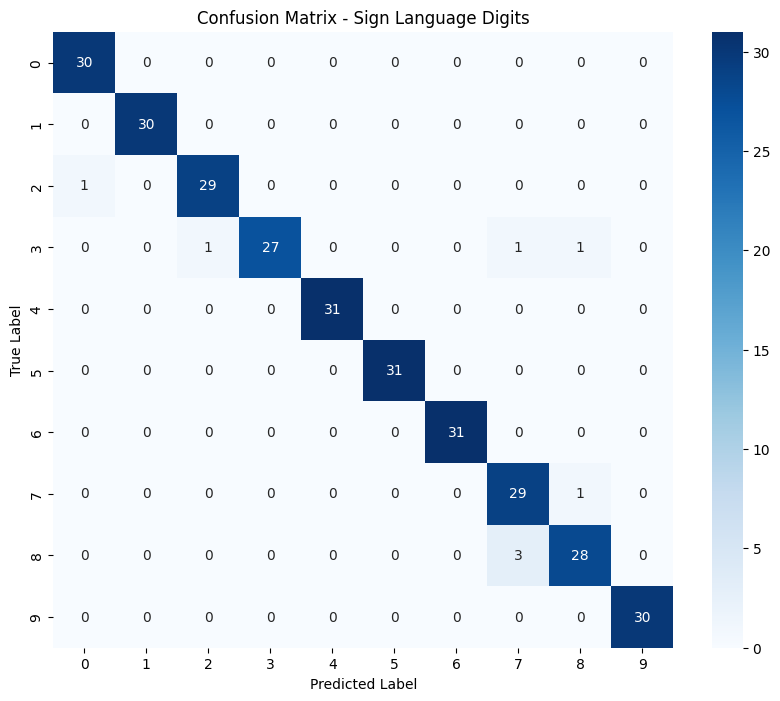


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        30
           2       0.97      0.97      0.97        30
           3       1.00      0.90      0.95        30
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        31
           7       0.88      0.97      0.92        30
           8       0.93      0.90      0.92        31
           9       1.00      1.00      1.00        30

    accuracy                           0.97       304
   macro avg       0.97      0.97      0.97       304
weighted avg       0.97      0.97      0.97       304



In [35]:
# Generate predictions for confusion matrix
eval_generator.reset()
predictions = model.predict(eval_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = eval_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Sign Language Digits')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, 
                          target_names=[str(i) for i in range(10)]))